In [2]:
import urllib.request
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import sys,os,glob
from pandas import HDFStore
from threading import Thread
from datetime import  datetime,timedelta
width = 13
base_link = "http://amk030.imces.ru/meteodata/AMK_030_BIN/2019/09_2019/"
%matplotlib inline
import warnings;
warnings.filterwarnings('ignore');

In [3]:
class obrabotka_danniy(object):
#-----------------------------------------------------------------------------------------------------------------------      

    @staticmethod
    def get_all_links_file(base_link=base_link):
        page = requests.get(base_link)
        soup = BeautifulSoup(page.content)
        result = []
        for link in soup.find_all('a', href=True):
            if (link['href'][-4]=='.' and link['href'][-1]=='B'):
                result.append(base_link + link['href'])
        return result

    @staticmethod
    def create_dir_for_downloading_files(base_link=base_link):
        path = os.path.abspath('') + '\\' + str(base_link.split('/')[-2])
        if not os.path.isdir(path):
            os.mkdir(path)
            return path
        else:
            return path
            
    @staticmethod
    def download_files(urls=None):
        if urls==None:
            urls = ["http://amk030.imces.ru/meteodata/AMK_030_BIN/2019/10_2019/10010008.19B",
                     "http://amk030.imces.ru/meteodata/AMK_030_BIN/2019/10_2019/10010018.19B",
                       "http://amk030.imces.ru/meteodata/AMK_030_BIN/2019/06_2019/06010030.19R"]
        for i,j in enumerate(urls):
            handle = urllib.request.urlopen(urls[i])
            #создаем папку с названием выбранной папки (нап: "09_2019")
            dir_name = obrabotka_danniy.create_dir_for_downloading_files()
            fname = os.path.basename(urls[i])
            full_name =os.path.join(dir_name,os.path.basename(urls[i]))
            with open(full_name, "wb") as f_handler:
                while True:
                    chunk = handle.read()
                    if not chunk:
                        break
                    f_handler.write(chunk)
                    
    @staticmethod
    def get_file_names_in_dir(directory="09_2019"):
        file_names = []
        file_name = os.path.join(os.path.abspath(''),directory)
        for i in glob.glob(file_name +"\\" + "*.19B"):
            file_names.append(i)
        return file_names

    @staticmethod
    def function_obrabotka(HDF='data_base.h5'):
        data_frame_list = []
        file_names = obrabotka_danniy.get_file_names_in_dir()
        with pd.HDFStore(HDF,  mode='w') as store:
            for i,j in enumerate(file_names):
                with open(j, "rb") as file:
                    content = file.read()
                    data_dopolnitelniy = np.frombuffer(content[:17], dtype=np.dtype('i1'))
                    data_dopolnitelniy = np.frombuffer(data_dopolnitelniy[:16], dtype=np.dtype('i2'))
                    date_temp = data_dopolnitelniy[:-1]
                    date_time = datetime(*date_temp).strftime("%d.%m.%Y %H:%M:%S.%f")
                    numpy_data_polojitelnie = np.frombuffer(content, dtype=np.dtype('B'))[17:-14]
                    numpy_data_polojitelnie = numpy_data_polojitelnie.reshape(int(len(numpy_data_polojitelnie) / width), width)
                    numpy_data_polojitelnie = np.delete(numpy_data_polojitelnie,12,1)
                    numpy_data_polojitelnie = np.frombuffer(numpy_data_polojitelnie, dtype=np.dtype('i2'))
                    numpy_data_polojitelnie = numpy_data_polojitelnie.reshape(int(len(numpy_data_polojitelnie)/6),6)
                    row = numpy_data_polojitelnie.shape[0]
                    column = numpy_data_polojitelnie.shape[1] + 1
                    zero = np.zeros((row,1))
                    numpy_data_polojitelnie = np.append(numpy_data_polojitelnie,zero,axis=1) 
                    for i in range(len(numpy_data_polojitelnie)):
                        numpy_data_polojitelnie[i,0] = numpy_data_polojitelnie[i,0] / 100
                        numpy_data_polojitelnie[i,1] = numpy_data_polojitelnie[i,1] / 100
                        numpy_data_polojitelnie[i,2] = numpy_data_polojitelnie[i,2] / 100
                        numpy_data_polojitelnie[i,3] = numpy_data_polojitelnie[i,3] / 100
                        numpy_data_polojitelnie[i,4] = numpy_data_polojitelnie[i,4] / 10
                        numpy_data_polojitelnie[i,5] = numpy_data_polojitelnie[i,5] / 100
                    datelist = pd.date_range(date_time, periods=len(numpy_data_polojitelnie), freq='12.5ms').to_pydatetime()
                    data_frame = pd.DataFrame({'Time': datelist, 'Температура': numpy_data_polojitelnie[:,0], 'Южный компонент': numpy_data_polojitelnie[:,1],
                                  'Восточный компонент': numpy_data_polojitelnie[:,2], 'Вертикальный компонент': numpy_data_polojitelnie[:,3],
                                  'Атмосферное давление': numpy_data_polojitelnie[:,4], 'Влажность воздуха': numpy_data_polojitelnie[:,5],
                                  'Признак ошибки': numpy_data_polojitelnie[:,6]})
                    data_frame_list.append(data_frame)
                
                    store.append('df', data_frame, data_columns= data_frame.columns, format='table')
                
        return data_frame_list
    
    
#############################################dopolnitelnie functions  
#-----------------------------------------------------BEGIN---------------------------------------------------------      
@staticmethod
def get_cut_links_files_for_threading(self): 
    links_files = get_all_links_file()
    cut_links_files = [[links_files[:1000]],
                       [links_files[1000:2000]],
                       [links_files[2000:3000]],
                       [links_files[3000:]]]
    return cut_links_files
@staticmethod    
def download_files_with_threading(self):
    func = obrabotka_danniy.download_files
    for i,j in enumerate(cut_links_files):
        my_thread = Thread(target=func, name=[i], args=(j,))
        my_thread.start()
        if i ==10:
            break
    
    
#------------------------------------------------------END-----------------------------------------------------------      


In [9]:
# получить ссылки для скачивание файла (тут получим 10 ссылок)
links = obrabotka_danniy.get_all_links_file()[:50]

In [10]:
len(links)

0

In [11]:
# тут скачивает из ссылки в выбранную папку (по умолчанию: "09_2019")
obrabotka_danniy.download_files(links)

In [4]:
# тут обрабативаем данные и вес обработанные данные записиваются в "data_base.h5"
obrabotka_danniy.function_obrabotka('data_base_1078')

[]

In [16]:
df = pd.read_hdf('data_base_1078')#читаем из базы
df.count()#количество значения

Time                      14991940
Температура               14991940
Южный компонент           14991940
Восточный компонент       14991940
Вертикальный компонент    14991940
Атмосферное давление      14991940
Влажность воздуха         14991940
Признак ошибки            14991940
dtype: int64

In [21]:
# cond1 = (pd.Timestamp(2019,6,6) < df['Time']) &  (df['Time'] < pd.Timestamp(2019,6,10))
# df.loc[cond1, ]
start_date = (2019,6,9)
end_date = (2019,7,14)
freq='1H' #выбирайте частота повторения
start_po_vremeni = 9
end_po_vremeni = 24

In [22]:
df[(df['Time'] >= pd.Timestamp(*start_date)) & (df['Time'] < pd.Timestamp(*end_date))]

,Time,Температура,Южный компонент,Восточный компонент,Вертикальный компонент,Атмосферное давление,Влажность воздуха,Признак ошибки
0,2019-06-09 09:26:06.000250,10.82,2.10,-0.22,-1.03,740.5,61.88,0.0
1,2019-06-09 09:26:06.012750,10.85,2.48,-0.12,-0.89,740.6,61.85,0.0
2,2019-06-09 09:26:06.025250,10.86,2.69,0.00,-0.83,740.6,61.84,0.0
3,2019-06-09 09:26:06.037750,10.91,2.59,-0.02,-0.87,740.6,61.84,0.0
4,2019-06-09 09:26:06.050250,10.91,2.51,-0.07,-0.75,740.6,61.82,0.0
5,2019-06-09 09:26:06.062750,10.89,2.49,-0.02,-0.66,740.6,61.80,0.0
6,2019-06-09 09:26:06.075250,10.87,2.28,-0.07,-0.70,740.6,61.80,0.0
7,2019-06-09 09:26:06.087750,10.91,2.40,-0.02,-0.77,740.6,61.79,0.0
8,2019-06-09 09:26:06.100250,10.90,2.27,-0.10,-0.89,740.6,61.80,0.0
9,2019-06-09 09:26:06.112750,10.91,2.32,-0.01,-0.91,740.6,61.79,0.0


                    Time    Average
0    2019-06-09 09:00:00  11.584928
1    2019-06-09 10:00:00  13.642993
2    2019-06-09 11:00:00  15.838889
3    2019-06-09 12:00:00  17.077501
4    2019-06-09 13:00:00  17.825356
5    2019-06-09 14:00:00  18.466004
6    2019-06-09 15:00:00  18.991234
7    2019-06-09 16:00:00  19.058800
8    2019-06-09 17:00:00  18.584235
9    2019-06-09 18:00:00  18.161854
10   2019-06-09 19:00:00  16.843657
11   2019-06-09 20:00:00  15.213707
12   2019-06-09 21:00:00  14.424435
13   2019-06-09 22:00:00  13.589275
14   2019-06-09 23:00:00  12.586722
15   2019-06-10 00:00:00        NaN
16   2019-06-10 01:00:00        NaN
17   2019-06-10 02:00:00        NaN
18   2019-06-10 03:00:00        NaN
19   2019-06-10 04:00:00        NaN
20   2019-06-10 05:00:00        NaN
21   2019-06-10 06:00:00        NaN
22   2019-06-10 07:00:00        NaN
23   2019-06-10 08:00:00        NaN
24   2019-06-10 09:00:00        NaN
25   2019-06-10 10:00:00        NaN
26   2019-06-10 11:00:00    

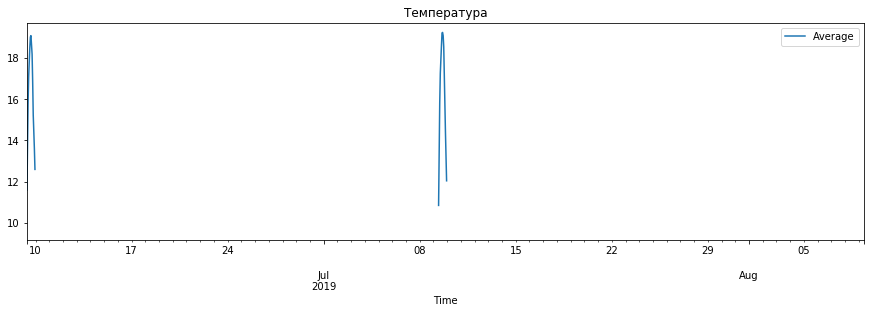

In [23]:
# df['Time'].dt.hour
res=df.groupby(pd.Grouper(key='Time',freq=freq,sort=True))['Южный компонент'].mean().reset_index(name='Average')
cond1 = (df['Time'].dt.hour >= start_po_vremeni) & (df['Time'].dt.hour < end_po_vremeni) 
df = df.loc[cond1, ]
res = (df.groupby(pd.Grouper(key='Time',freq=freq,sort=True))['Температура'].mean().reset_index(name='Average'))
print(res)
res.plot(x='Time', y='Average',title='Температура',figsize=(15,4))

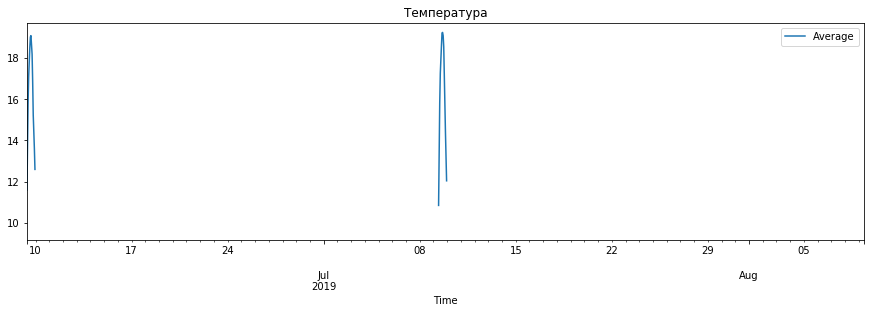

In [24]:
res = (df.groupby(pd.Grouper(key='Time',freq=freq,sort=True))['Температура'].mean().reset_index(name='Average'))
res.plot(x='Time', y='Average',title='Температура',figsize=(15,4))

In [11]:
res = (df.groupby(pd.Grouper(key='Time',freq=freq,sort=True))['Южный компонент'].mean().reset_index(name='Average'))
res.plot(x='Time', y='Average',title='Южный компонент',figsize=(15,4))

NameError: name 'df' is not defined

In [ ]:
res = (df.groupby(pd.Grouper(key='Time',freq=freq,sort=True))['Восточный компонент'].mean().reset_index(name='Average'))
res.plot(x='Time', y='Average',title='Восточный компонент',figsize=(15,4))

In [ ]:
res = (df.groupby(pd.Grouper(key='Time',freq=freq,sort=True))['Вертикальный компонент'].mean().reset_index(name='Average'))
res.plot(x='Time', y='Average',title='Вертикальный компонент',figsize=(15,4)) 

In [ ]:
res = (df.groupby(pd.Grouper(key='Time',freq=freq,sort=True))['Атмосферное давление'].mean().reset_index(name='Average'))
res.plot(x='Time', y='Average',title='Атмосферное давление',figsize=(15,4))

In [ ]:
res = (df.groupby(pd.Grouper(key='Time',freq=freq,sort=True))['Влажность воздуха'].mean().reset_index(name='Average'))
res.plot(x='Time', y='Average',title='Влажность воздуха',figsize=(15,4))

In [ ]:
res.describe()

In [ ]:
res = df.groupby('Time') 

In [ ]:
df = pd.DataFrame({'A': ['bar','foo','foo'],
                  'B':[10,20,20],
                  'C':[10,20,30],
                  'D':[10,20,30],} )


In [ ]:
df

In [ ]:
grouped = df.groupby('A')

In [ ]:
grouped.aggregate(np.sum)

In [ ]:
grouped = df.groupby(['A'])
grouped.agg([np.sum, np.mean, np.std]).reset_index()